# Cyberbullying On Social Media

# Convolutional Neural Networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt  
import seaborn as sns
import os
import math

import imblearn
from imblearn.over_sampling import SMOTE


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# filter warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import tensorflow as tf
from tensorflow import keras
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Flatten, Add, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Activation, Input, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import PIL.Image as Image

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

**CNN**

Convolutional Neural Network (CNN)  models were developed for image classification, in which the model accepts a two-dimensional input representing an image’s pixels and color channels, in a process called feature learning.

This same process can be applied to one-dimensional sequences of data. The model extracts features from sequences data and maps the internal features of the sequence. A 1D CNN is very effective for deriving features from a fixed-length segment of the overall dataset, where it is not so important where the feature is located in the segment.

CNNs work well for:

- Analysis of a time series of sensor data.
- Analysis of signal data over a fixed-length period, for example, an audio recording.
- Natural Language Processing (NLP), although according to my research Recurrent Neural Networks which leverage Long Short Term Memory (LSTM) cells might be more promising than CNN as they take into account the proximity of words to create trainable patterns.


CNNs work the same way whether they have 1, 2, or 3 dimensions. The difference is the structure of the input data and how the filter, also known as a convolution kernel or feature detector, moves across the data.

In [2]:
#keep the same random state for reproducibility
RANDOM_STATE = 12

TRAIN_TEST_SPLIT_SIZE = 0.1
VALIDATION_SPLIT_SIZE = 0.2

In [3]:
df = pd.read_csv('labeled_insta_cleaned.csv', encoding='utf-8-sig', engine='python')

In [4]:
comments = df['tidy_text'].values
labels = df['label_bullying'].values

In [5]:
x_train_val, x_test, y_train_val, y_test = train_test_split(comments, labels, stratify = labels, 
                                                            test_size = TRAIN_TEST_SPLIT_SIZE, 
                                                            random_state = RANDOM_STATE)

Since I'm not using GridSearchCV for the neural networks I will create a validation dataset here. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify = y_train_val, 
                                                  test_size = VALIDATION_SPLIT_SIZE, 
                                                  random_state = RANDOM_STATE)

In [7]:
# MAX_SEQUENCE_LENGTH = max(len(x) for x in x_train) # longest text in train set
MAX_SEQUENCE_LENGTH = 100 # average length of texts

In [8]:
# summarize class distribution for train
neg, pos = np.bincount(y_train)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 7943
    Positive: 2291 (28.84% of total)



In [9]:
# summarize class distribution for validation
neg, pos = np.bincount(y_val)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1986
    Positive: 573 (28.85% of total)



In [10]:
# summarize class distribution for test
neg, pos = np.bincount(y_test)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1104
    Positive: 319 (28.89% of total)



***

**Utility Functions**

***

In [11]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [12]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'], color = colors[n], label = 'Train ' + label)
    plt.semilogy(history.epoch,  history.history['val_loss'], color = colors[n], label = 'Val ' + label, linestyle = "--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [13]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(history.epoch,  history.history[metric], color = colors[0], label = 'Train')
        plt.plot(history.epoch, history.history['val_' + metric], color = colors[1], linestyle = "--", label = 'Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

In [14]:
def plot_cfm(labels, predictions, p = 0.5):
    cfm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize = (5,5))
    sns.heatmap(cfm, annot = True, fmt = "d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual values')
    plt.xlabel('Predicted values')

    print('True Negatives: ', cfm[0][0])
    print('False Positives: ', cfm[0][1])
    print('False Negatives: ', cfm[1][0])
    print('True Positives: ', cfm[1][1])

In [15]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    roc_auc = metrics.auc(fp, tp)    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fp, tp, label = name + ' AUC = %0.2f' % roc_auc, linewidth = 2, **kwargs)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1], linewidth = 2, color = colors[6], linestyle = ':')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

***

**Prepare datasets**

In [16]:
# Tokenize and transform to integer index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(comments)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_val = tokenizer.texts_to_sequences(x_val)


word_index = tokenizer.word_index
print('Unique tokens:', len(word_index))

x_train = pad_sequences(x_train, maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test, maxlen = MAX_SEQUENCE_LENGTH)
x_val = pad_sequences(x_val, maxlen = MAX_SEQUENCE_LENGTH)

Unique tokens: 55121


In [17]:
MAX_NUM_WORDS = len(word_index) + 1

In [18]:
#transform the training dataset only
sm = SMOTE(random_state = RANDOM_STATE)
x_train_sm, y_train_sm = sm.fit_sample(x_train, y_train)

Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

In [19]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_train_sm = scaler.fit_transform(x_train_sm)

x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [20]:
print('Training dataset shape:', x_train.shape)
print('Resampled training dataset shape:', x_train_sm.shape)
print('Validation dataset shape:', x_val.shape)
print('Test dataset shape:', x_test.shape)

Training dataset shape: (7943, 100)
Resampled training dataset shape: (11304, 100)
Validation dataset shape: (1986, 100)
Test dataset shape: (1104, 100)


In [21]:
x_train = np.expand_dims(x_train, axis = 2)
x_train_sm = np.expand_dims(x_train_sm, axis = 2)
x_test = np.expand_dims(x_test, axis = 2)
x_val = np.expand_dims(x_val, axis = 2)

**Define the model and metrics**

Currently, F1-score is not considered by the authors to be a meaningful metric in keras neural network models, because keras will call F1-score at each batch step at validation, which results in too small values. Therefore, F1-score was removed from keras. Fortunately keras still provides precision, recall and auc as metrics.

In [22]:
KERAS_METRICS = [
      keras.metrics.TruePositives(name = 'tp'),
      keras.metrics.FalsePositives(name = 'fp'),
      keras.metrics.TrueNegatives(name = 'tn'),
      keras.metrics.FalseNegatives(name = 'fn'), 
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.Precision(name = 'precision'),
      keras.metrics.Recall(name = 'recall'),
      keras.metrics.AUC(name = 'auc'),
]

The generic architecture of the model I've decided to use groups of two 1D CNN layers, followed by a pooling layer, then a dropout layer for regularization. Based on my research and also on the failed experiences with the different previous architectures I have decided to go for a deeper rather than wider architecture.

It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1/2 their size, consolidating them to only the most essential elements.

After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction.

The efficient Adam version of stochastic gradient descent will be used to optimize the network, and the binary cross entropy loss function will be used given that we are learning a binary classification problem.

Additionally, there are two options to vectorize the data for Keras:

- **Option 1**: Make it part of the model, so as to obtain a model that processes raw strings. This is what we will do here with the Keras Embeddings Layer, and using the pretrained Glove/FastTest embeddings.

- **Option 2**: Apply it to the text dataset to obtain a dataset of word indices, then feed it into a model that expects integer sequences as inputs. This is what we will do with TFIDF and Word2Vec.

In [23]:
def make_basic_model(metrics = KERAS_METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)       
        
    model = Sequential()

    model.add(Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid',
                         bias_initializer=output_bias))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=KERAS_METRICS)

    return model

Now let's create and train the model using the function defined earlier. The model is fit using a relatively larger than default batch size, so as to ensure that each batch has a decent chance of containing a few negative samples. If the batch size is too small, they would likely have no negative comments to learn from.

Note: this model will not handle the class imbalance well. It is used here as a baseline.

In [24]:
model = make_basic_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 96, 16)            96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 48, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 16)            1296      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 22, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 352)               0         
_________________________________________________________________
dropout (Dropout)            (None, 352)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               4

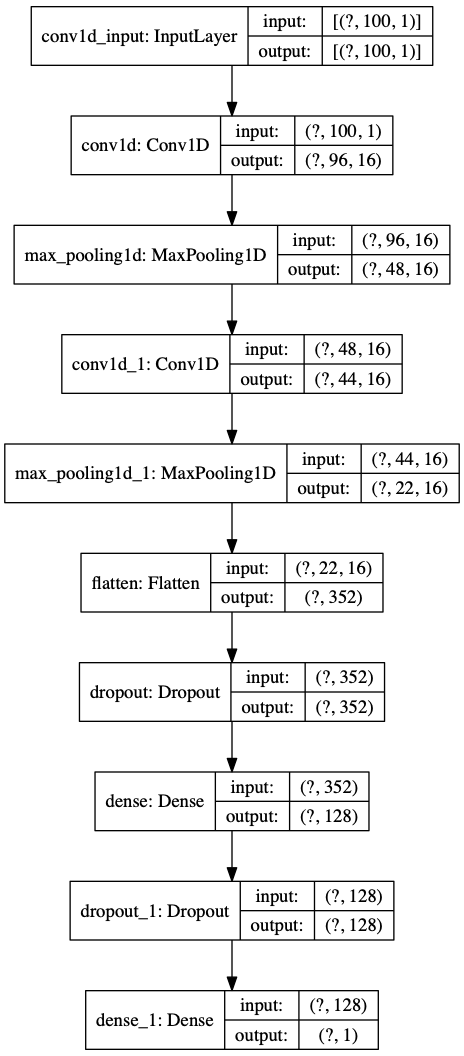

In [25]:
plot_model(model, to_file='initial_model.png', show_shapes=True, show_layer_names=True)
im = Image.open('initial_model.png')
im

**Number of epochs and batch size**

The number of epochs and the batch size are also tunable parameters. We would in general want to use a larger batch size to train the model as it allows computational speed up from the parallelism. However, it is known that too large of a batch size will lead to poor generalization (although currently it’s not known why this is so). I have experimented with batch sizes of 16, 32, 64 and 128, and let the algorithm run for 100 epochs. In order to prevent overfitting I relied on early stopping.

**Early stopping**

When we’re training a learning algorithm iteratively, we can measure how well each iteration of the model performs. Up until a certain number of iterations, new iterations improve the model. After that point, however, the model’s ability to generalize can weaken as it begins to overfit the training data. Early stopping refers stopping the training process before the learner passes that point.

In [26]:
# The exact amount of patience will vary between models and problems and is difficult to calculate exactly. 
# I've seen recommendations as a rule of thumb to use 10% of the number of epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_auc', 
    verbose = 2,
    patience = 10,
    mode = 'max',
    restore_best_weights = True)

In [27]:
callbacks = [early_stopping]

In [28]:
EPOCHS = 100
BATCH_SIZE = 512

Here we set the batch size very high, to be able to capture at least some bullying comments per batch.

Test run the model on 10 samples.

In [29]:
model.predict(x_train[:10])

array([[0.1681259 ],
       [0.16813889],
       [0.15685558],
       [0.16812375],
       [0.16559076],
       [0.16808268],
       [0.16797441],
       [0.19221866],
       [0.16803782],
       [0.20142023]], dtype=float32)

We know that the dataset is unbalanced, so without using SMOTE (for now), we should set the output layer's bias to reflect the imbalance (See: A Recipe for Training Neural Networks: "init well", link below). This can help with initial convergence.


http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines

From the article: "Initialize the final layer weights correctly. E.g. if you are regressing some values that have a mean of 50 then initialize the final bias to 50. If you have an imbalanced dataset of a ratio 1:10 of positives:negatives, set the bias on your logits such that your network predicts probability of 0.1 at initialization. Setting these correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias."

In [30]:
results = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6499


Let's try to figure out what a good initial bias might be to reduce the loss.

In [31]:
initial_bias = np.log([pos/neg])
initial_bias

array([-0.90049261])

In [32]:
model = make_basic_model(output_bias = initial_bias)

In [33]:
model.predict(x_train[:10])

array([[0.28661835],
       [0.28661254],
       [0.3047919 ],
       [0.28672713],
       [0.28933722],
       [0.28675646],
       [0.2871555 ],
       [0.32849294],
       [0.28664988],
       [0.3438277 ]], dtype=float32)

In [34]:
results = model.evaluate(x_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6176


Notice the difference in the loss by using biased initialization. The idea behind it is that this way the model doesn't need to spend the first few epochs just learning that bullying comments are more unlikely. 

***

**Biased Initialization**

***

In [35]:
initial_weights = os.path.join(".",'initial_weights')
model.save_weights(initial_weights)

In [36]:
model = make_basic_model()
model.load_weights(initial_weights)
baseline_history = model.fit(x_train, y_train,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    callbacks = callbacks,
                    validation_data = (x_val, y_val))

Train on 7943 samples, validate on 1986 samples
Epoch 1/100
7943/7943 [==============================] - 3s 438us/sample - loss: 0.6299 - tp: 54.0000 - fp: 160.0000 - tn: 5492.0000 - fn: 2237.0000 - accuracy: 0.6982 - precision: 0.2523 - recall: 0.0236 - auc: 0.5080 - val_loss: 0.6057 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1413.0000 - val_fn: 573.0000 - val_accuracy: 0.7115 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5270
Epoch 2/100
7943/7943 [==============================] - 1s 80us/sample - loss: 0.6052 - tp: 31.0000 - fp: 59.0000 - tn: 5593.0000 - fn: 2260.0000 - accuracy: 0.7080 - precision: 0.3444 - recall: 0.0135 - auc: 0.5264 - val_loss: 0.5989 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1413.0000 - val_fn: 573.0000 - val_accuracy: 0.7115 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5365
Epoch 3/100
7943/7943 [==============================] - 1s 87us/sample - loss: 0.6014 - tp: 12.0000 - fp: 44.0000 - tn: 5608.00

Epoch 21/100
7943/7943 [==============================] - 1s 67us/sample - loss: 0.5888 - tp: 25.0000 - fp: 20.0000 - tn: 5632.0000 - fn: 2266.0000 - accuracy: 0.7122 - precision: 0.5556 - recall: 0.0109 - auc: 0.5746 - val_loss: 0.5948 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 1413.0000 - val_fn: 573.0000 - val_accuracy: 0.7115 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5648
Epoch 22/100
7943/7943 [==============================] - 1s 68us/sample - loss: 0.5882 - tp: 28.0000 - fp: 22.0000 - tn: 5630.0000 - fn: 2263.0000 - accuracy: 0.7123 - precision: 0.5600 - recall: 0.0122 - auc: 0.5789 - val_loss: 0.5925 - val_tp: 1.0000 - val_fp: 1.0000 - val_tn: 1412.0000 - val_fn: 572.0000 - val_accuracy: 0.7115 - val_precision: 0.5000 - val_recall: 0.0017 - val_auc: 0.5813
Epoch 23/100
7943/7943 [==============================] - 1s 83us/sample - loss: 0.5886 - tp: 45.0000 - fp: 32.0000 - tn: 5620.0000 - fn: 2246.0000 - accuracy: 0.7132 - precision: 0.5844 - rec

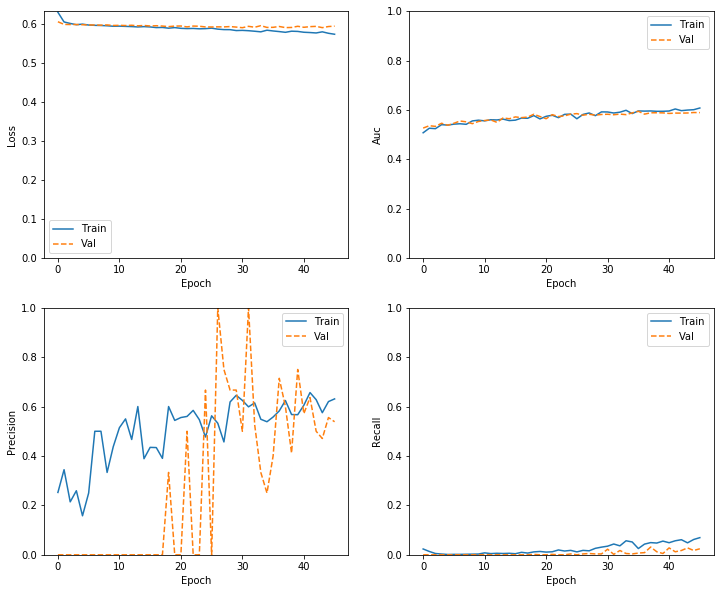

In [37]:
plot_metrics(baseline_history)

In [38]:
y_probas_train_baseline = model.predict(x_train)
y_probas_test_baseline = model.predict(x_test)

In [39]:
# Get most likely class
y_pred_test_baseline = np.round(y_probas_test_baseline) 

True Negatives:  783
False Positives:  2
False Negatives:  315
True Positives:  4


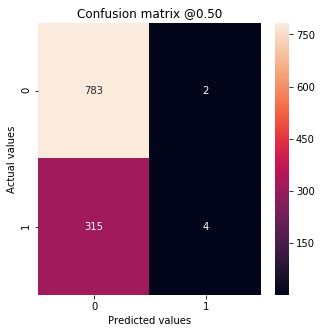

In [40]:
plot_cfm(y_test, y_probas_test_baseline)

In [41]:
print(classification_report(y_test, y_pred_test_baseline))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       785
           1       0.67      0.01      0.02       319

    accuracy                           0.71      1104
   macro avg       0.69      0.50      0.43      1104
weighted avg       0.70      0.71      0.60      1104



These results are not surprising. Due to the imbalance, the model is not capable of recognizing bullying comments as such, resulting in only 4 true positives.

In [42]:
f1_baseline = f1_score(y_test, y_pred_test_baseline, average = 'weighted')
print('Baseline F1: %.2f' % f1_baseline)

Baseline F1: 0.60


In [43]:
auc_baseline = roc_auc_score(y_test, y_probas_test_baseline)
print('Baseline AUC: %.2f' % auc_baseline)

Baseline AUC: 0.59


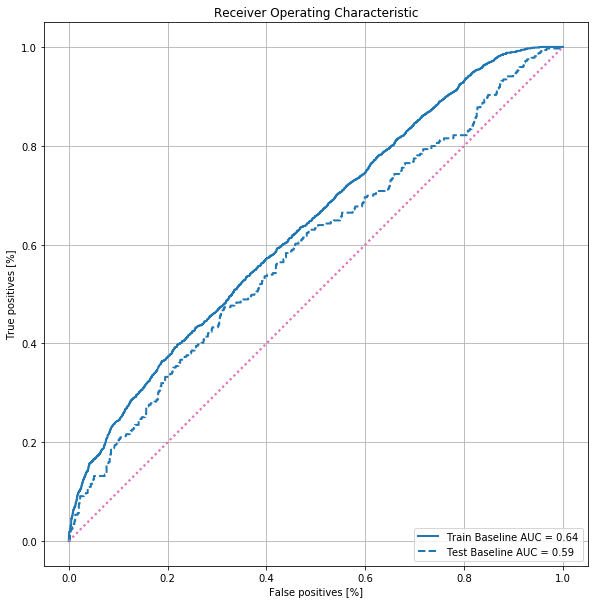

In [44]:
plot_roc("Train Baseline", y_train, y_probas_train_baseline, color = colors[0])
plot_roc("Test Baseline", y_test, y_probas_test_baseline, color = colors[0], linestyle = '--')

***

**Class Weights**

***

In [45]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.70
Weight for class 1: 1.73


In [46]:
weighted_model = make_basic_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(x_train, y_train,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    callbacks = callbacks,
                    validation_data = (x_val, y_val),
                    # calculated class weights 
                    class_weight = class_weight) 

Train on 7943 samples, validate on 1986 samples
Epoch 1/100
7943/7943 [==============================] - 4s 495us/sample - loss: 0.7782 - tp: 297.0000 - fp: 774.0000 - tn: 4878.0000 - fn: 1994.0000 - accuracy: 0.6515 - precision: 0.2773 - recall: 0.1296 - auc: 0.4890 - val_loss: 0.7154 - val_tp: 49.0000 - val_fp: 150.0000 - val_tn: 1263.0000 - val_fn: 524.0000 - val_accuracy: 0.6606 - val_precision: 0.2462 - val_recall: 0.0855 - val_auc: 0.4793
Epoch 2/100
7943/7943 [==============================] - 1s 86us/sample - loss: 0.7156 - tp: 1034.0000 - fp: 2461.0000 - tn: 3191.0000 - fn: 1257.0000 - accuracy: 0.5319 - precision: 0.2959 - recall: 0.4513 - auc: 0.5079 - val_loss: 0.6950 - val_tp: 427.0000 - val_fp: 1040.0000 - val_tn: 373.0000 - val_fn: 146.0000 - val_accuracy: 0.4028 - val_precision: 0.2911 - val_recall: 0.7452 - val_auc: 0.5170
Epoch 3/100
7943/7943 [==============================] - 1s 74us/sample - loss: 0.7016 - tp: 833.0000 - fp: 2040.0000 - tn: 3612.0000 - fn: 1458.000

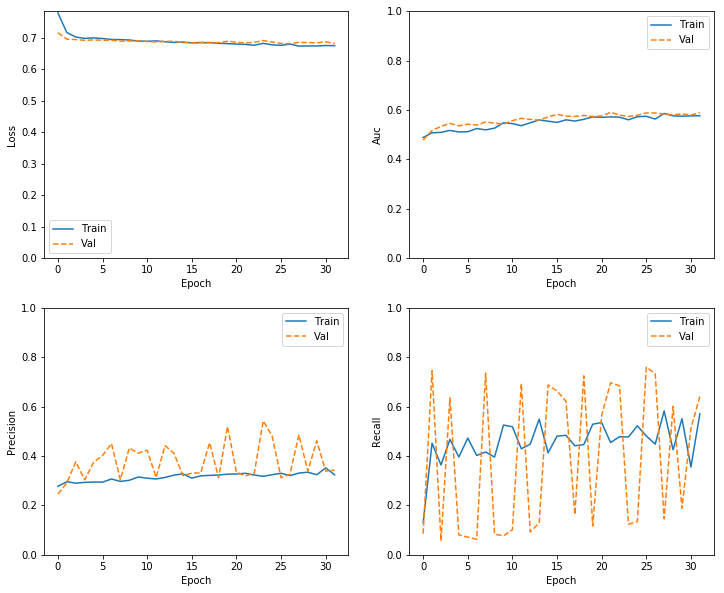

In [47]:
plot_metrics(weighted_history)

In [48]:
y_probas_train_weighted = weighted_model.predict(x_train)
y_probas_test_weighted = weighted_model.predict(x_test)

In [49]:
# Get most likely class
y_pred_test_weighted = np.round(y_probas_test_weighted)

True Negatives:  335
False Positives:  450
False Negatives:  98
True Positives:  221


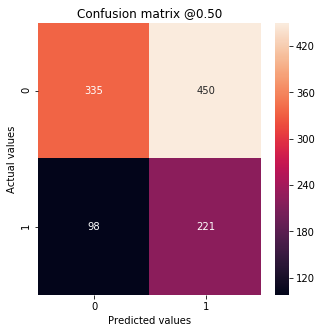

In [50]:
plot_cfm(y_test, y_probas_test_weighted)

In [51]:
print(classification_report(y_test, y_pred_test_weighted))

              precision    recall  f1-score   support

           0       0.77      0.43      0.55       785
           1       0.33      0.69      0.45       319

    accuracy                           0.50      1104
   macro avg       0.55      0.56      0.50      1104
weighted avg       0.65      0.50      0.52      1104



Weighting on the other hand, seems to have the opposite effect, tipping the scales in the opposite direction: the model find a lot of true positives but also a considerably large amount of false positives as well. 

In [52]:
f1_weighted = f1_score(y_test, y_pred_test_weighted, average = 'weighted')
print('Weighted F1: %.2f' % f1_weighted)

Weighted F1: 0.52


In [53]:
auc_weighted = roc_auc_score(y_test, y_probas_test_weighted)
print('Weighted AUC: %.2f' % auc_weighted)

Weighted AUC: 0.60


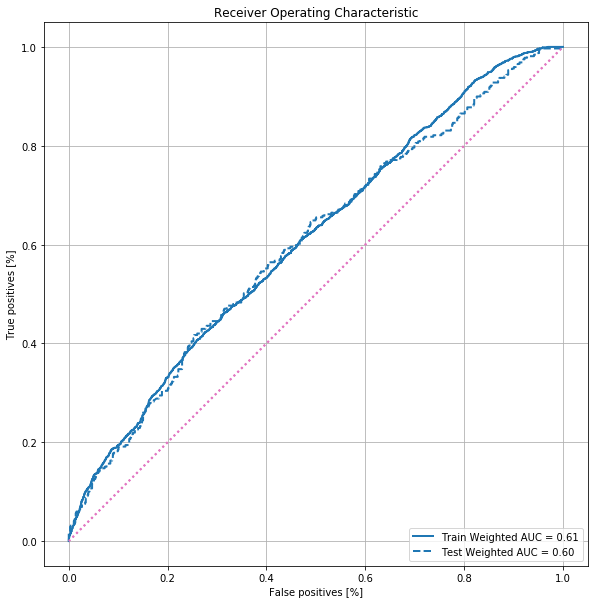

In [54]:
plot_roc("Train Weighted", y_train, y_probas_train_weighted, color = colors[0])
plot_roc("Test Weighted", y_test, y_probas_test_weighted, color = colors[0], linestyle = '--')

It looks like the precision is lower when using weghting, but the recall is significantly better, especially for the negative class. The area under the ROC curve (AUC) doesn't show a big improvement. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with unbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem. For example, if I were to use this algorithm to detect and potentially block users which make bullying comments from the social media network, a false negative (a bullying comment is missed) might defeat the purpose, while a false positive (a normal comment is incorrectly flagged as bullying) may decrease user happiness (it might lead to legitimate comments or users being blocked).

***

**Oversampling using SMOTE**

***

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal is supposed to make it easier to train the model.

In [55]:
BATCH_SIZE = 32

In [56]:
resampled_model = make_basic_model()

resampled_history = resampled_model.fit(x_train_sm, y_train_sm,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    callbacks = callbacks,
                    validation_data = (x_val, y_val)) 

Train on 11304 samples, validate on 1986 samples
Epoch 1/100
11304/11304 [==============================] - 5s 433us/sample - loss: 0.7218 - tp: 2267.0000 - fp: 2194.0000 - tn: 3458.0000 - fn: 3385.0000 - accuracy: 0.5065 - precision: 0.5082 - recall: 0.4011 - auc: 0.5081 - val_loss: 0.6677 - val_tp: 82.0000 - val_fp: 117.0000 - val_tn: 1296.0000 - val_fn: 491.0000 - val_accuracy: 0.6939 - val_precision: 0.4121 - val_recall: 0.1431 - val_auc: 0.5478
Epoch 2/100
11304/11304 [==============================] - 3s 229us/sample - loss: 0.6920 - tp: 2631.0000 - fp: 2352.0000 - tn: 3300.0000 - fn: 3021.0000 - accuracy: 0.5247 - precision: 0.5280 - recall: 0.4655 - auc: 0.5473 - val_loss: 0.6956 - val_tp: 441.0000 - val_fp: 994.0000 - val_tn: 419.0000 - val_fn: 132.0000 - val_accuracy: 0.4330 - val_precision: 0.3073 - val_recall: 0.7696 - val_auc: 0.5464
Epoch 3/100
11304/11304 [==============================] - 4s 319us/sample - loss: 0.6824 - tp: 2721.0000 - fp: 2328.0000 - tn: 3324.0000 - f

I'm expecting the distributions of metrics to be different here, because the training data has a totally different distribution from the validation and test data. 

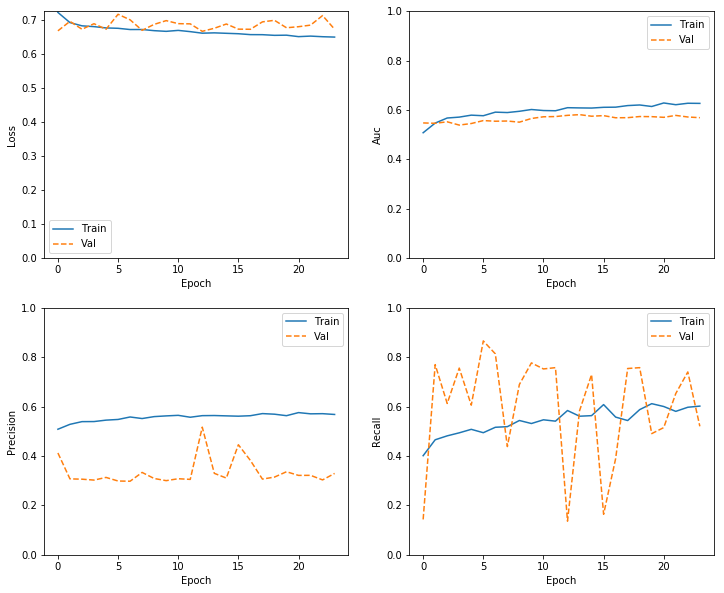

In [57]:
plot_metrics(resampled_history )

In [58]:
y_probas_train_resampled = resampled_model.predict(x_train_sm)
y_probas_test_resampled = resampled_model.predict(x_test)

In [59]:
y_pred_test_resampled = np.round(y_probas_test_resampled)

True Negatives:  436
False Positives:  349
False Negatives:  133
True Positives:  186


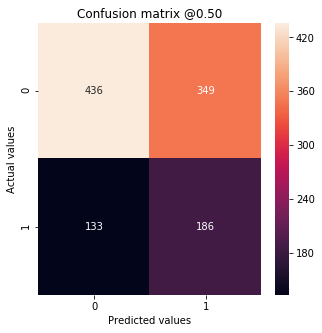

In [60]:
plot_cfm(y_test, y_pred_test_resampled)

In [61]:
print(classification_report(y_test, y_pred_test_resampled))

              precision    recall  f1-score   support

           0       0.77      0.56      0.64       785
           1       0.35      0.58      0.44       319

    accuracy                           0.56      1104
   macro avg       0.56      0.57      0.54      1104
weighted avg       0.65      0.56      0.58      1104



In [62]:
f1_resampled = f1_score(y_test, y_pred_test_resampled, average = 'weighted')
print('Resampled F1: %.2f' % f1_resampled)

Resampled F1: 0.58


In [63]:
auc_resampled = roc_auc_score(y_test, y_probas_test_resampled)
print('Resampled AUC: %.2f' % auc_resampled)

Resampled AUC: 0.60


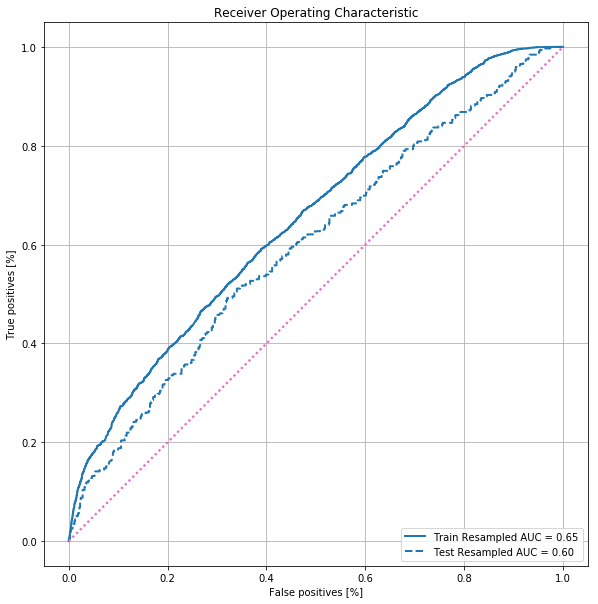

In [64]:
plot_roc("Train Resampled", y_train_sm, y_probas_train_resampled, color = colors[0])
plot_roc("Test Resampled", y_test, y_probas_test_resampled, color = colors[0], linestyle = '--')

***

**Comparison**

***

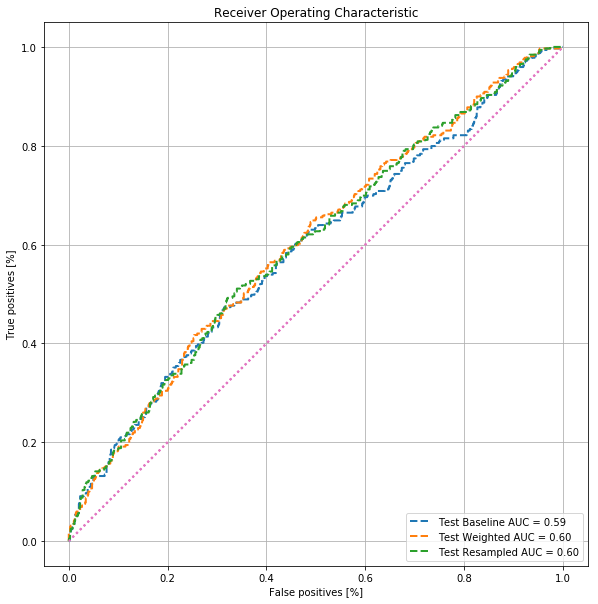

In [65]:
plot_roc("Test Baseline", y_test, y_probas_test_baseline, color = colors[0], linestyle = '--')

plot_roc("Test Weighted", y_test, y_probas_test_weighted, color = colors[1], linestyle = '--')

plot_roc("Test Resampled", y_test, y_probas_test_resampled,  color = colors[2], linestyle = '--')